In [ ]:
import pandas as pd
import sqlite3
import numpy as np

# 1. Import, Restructure, and Clean Data

In [21]:
#define connection
conn = sqlite3.connect('database.sqlite')

In [22]:
#write query for first import (weather)
query = """SELECT date, mean_temperature_f, precipitation_inches, mean_wind_speed_mph FROM weather"""

In [23]:
#read in the weather table. set index as date to prevent multiindex default
weather = pd.read_sql_query(query, conn, parse_dates = ['date'], index_col = 'date')
weather.reset_index(inplace = True)
weather.replace("", np.nan)

,date,mean_temperature_f,precipitation_inches,mean_wind_speed_mph
0,2013-08-29,68.0,0,11.0
1,2013-08-30,69.0,0,13.0
2,2013-08-31,64.0,0,15.0
3,2013-09-01,66.0,0,13.0
4,2013-09-02,69.0,0,12.0
...,...,...,...,...
3660,2015-08-27,78.0,0,6.0
3661,2015-08-28,80.0,0,7.0
3662,2015-08-29,72.0,0,9.0
3663,2015-08-30,70.0,0,10.0


In [24]:
#drop NAs from the weather table
weather.dropna(inplace = True)

In [25]:
#sort weather df by date, and drop the duplicates, keeping the first instance of each
weather.sort_values(by = 'date', inplace = True)
weather = weather[weather.mean_temperature_f != '']
weather_drop = weather.drop_duplicates(subset = 'date', keep = 'first').reset_index().drop('index', axis=1)

In [26]:
# replace all instance of T (trace) in the precip column with 0.005
weather_drop['precipitation_inches'].replace('T', 0.005, inplace = True)

In [29]:
#convert precip and temp/wind cols to flt and int dtypes respectively
weather_drop['precipitation_inches'].astype('float')
weather_drop[['mean_temperature_f', 'mean_wind_speed_mph']] = weather_drop[['mean_temperature_f', 'mean_wind_speed_mph']].astype('int')

In [30]:
#extract year and day number from date col, and drop date col
weather_drop['dayofyear'] = weather_drop['date'].dt.dayofyear
weather_drop['year'] = weather_drop['date'].dt.year
weather_drop.drop('date', axis = 1, inplace = True)
weather_drop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 733 entries, 0 to 732
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   mean_temperature_f    733 non-null    int32  
 1   precipitation_inches  733 non-null    float64
 2   mean_wind_speed_mph   733 non-null    int32  
 3   dayofyear             733 non-null    int64  
 4   year                  733 non-null    int64  
dtypes: float64(1), int32(2), int64(2)
memory usage: 23.0 KB


In [31]:
#read in status table, only taking entries every 5 mins (on the 0 and 5)
query = """SELECT station_id, bikes_available, time 
            FROM status"""

status = pd.read_sql_query(query, conn, parse_dates = 'time')

In [32]:
status.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71984434 entries, 0 to 71984433
Data columns (total 3 columns):
 #   Column           Dtype         
---  ------           -----         
 0   station_id       int64         
 1   bikes_available  int64         
 2   time             datetime64[ns]
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.6 GB


In [33]:
#break down the datetime into its individual features and drop the original datetime
status['dayofweek'] = status['time'].dt.dayofweek
status['min_in_day'] = status['time'].dt.hour * 60 + status['time'].dt.minute
status['dayofyear'] = status['time'].dt.dayofyear
status['year'] = status['time'].dt.year

status.drop('time', axis = 1, inplace = True)

status.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71984434 entries, 0 to 71984433
Data columns (total 6 columns):
 #   Column           Dtype
---  ------           -----
 0   station_id       int64
 1   bikes_available  int64
 2   dayofweek        int64
 3   min_in_day       int64
 4   dayofyear        int64
 5   year             int64
dtypes: int64(6)
memory usage: 3.2 GB


In [34]:
#merge status and weather dfs on 'dayofyear' and 'year'. 
status = status.merge(weather_drop, how = 'left', on = ['dayofyear', 'year'])
status.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71984434 entries, 0 to 71984433
Data columns (total 9 columns):
 #   Column                Dtype  
---  ------                -----  
 0   station_id            int64  
 1   bikes_available       int64  
 2   dayofweek             int64  
 3   min_in_day            int64  
 4   dayofyear             int64  
 5   year                  int64  
 6   mean_temperature_f    int32  
 7   precipitation_inches  float64
 8   mean_wind_speed_mph   int32  
dtypes: float64(1), int32(2), int64(6)
memory usage: 4.8 GB


# 3. Data Preprocessing

In [35]:
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split

In [36]:
#convert station_id and year to categeoricals, then one-hot encode them
status[['station_id', 'year', 'dayofweek']] = status[['station_id', 'year', 'dayofweek']] .astype('category')
status = pd.get_dummies(status)
status.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71984434 entries, 0 to 71984433
Data columns (total 86 columns):
 #   Column                Dtype  
---  ------                -----  
 0   bikes_available       int64  
 1   min_in_day            int64  
 2   dayofyear             int64  
 3   mean_temperature_f    int32  
 4   precipitation_inches  float64
 5   mean_wind_speed_mph   int32  
 6   station_id_2          uint8  
 7   station_id_3          uint8  
 8   station_id_4          uint8  
 9   station_id_5          uint8  
 10  station_id_6          uint8  
 11  station_id_7          uint8  
 12  station_id_8          uint8  
 13  station_id_9          uint8  
 14  station_id_10         uint8  
 15  station_id_11         uint8  
 16  station_id_12         uint8  
 17  station_id_13         uint8  
 18  station_id_14         uint8  
 19  station_id_16         uint8  
 20  station_id_21         uint8  
 21  station_id_22         uint8  
 22  station_id_23         uint8  
 23  stati

In [37]:
#take a sample of size sample_size from status_merge to do test runs on ML model
#using the same var name so that this cell can be easily removed for the full run
sample_size = 1*10**6
status = status.sample(n = sample_size, random_state = 42)

In [38]:
#create X and y
bikes = status['bikes_available']
status = status.drop('bikes_available', axis = 1)

In [39]:
#normalize all values in X
status = scale(status)

In [41]:
#find the shape of X_scale to use as the input dimension
h, w = status.shape

85

In [42]:
#create a train/test split of the data set being used in the model
X_train, X_test, y_train, y_test = train_test_split(status, bikes, test_size = 0.2, random_state = 21)

# 4. Create Neural Net ML Model

In [43]:
#import necessary elements of ML model
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

Using TensorFlow backend.
C:\Users\dalli\anaconda3\envs\Python ML\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\dalli\anaconda3\envs\Python ML\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\dalli\anaconda3\envs\Python ML\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\dalli\anaconda3\envs\Pytho

In [44]:
#instantiate model
model = Sequential()

#create model layers
model.add(Dense(32, input_shape = (w,), activation = 'relu'))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse', metrics = ['mse'])

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 3)

In [45]:
#run the model, saving the results to history
history = model.fit(X_train, y_train, 
                    epochs = 15,
                    validation_data = (X_test, y_test),
                    callbacks = [early_stopping])


Train on 800000 samples, validate on 200000 samples
Epoch 1/15
800000/800000 [==============================] - 23s 28us/step - loss: 11.3546 - mse: 11.3546 - val_loss: 10.7819 - val_mse: 10.7819
Epoch 2/15
800000/800000 [==============================] - 23s 29us/step - loss: 10.1705 - mse: 10.1705 - val_loss: 9.8365 - val_mse: 9.8365
Epoch 3/15
800000/800000 [==============================] - 23s 29us/step - loss: 9.6169 - mse: 9.6169 - val_loss: 9.6092 - val_mse: 9.6092
Epoch 4/15
800000/800000 [==============================] - 23s 28us/step - loss: 9.4321 - mse: 9.4321 - val_loss: 9.3699 - val_mse: 9.3699
Epoch 5/15
800000/800000 [==============================] - 23s 28us/step - loss: 9.3110 - mse: 9.3110 - val_loss: 9.2669 - val_mse: 9.2669
Epoch 6/15
800000/800000 [==============================] - 25s 31us/step - loss: 9.2256 - mse: 9.2256 - val_loss: 9.2533 - val_mse: 9.2532
Epoch 7/15
800000/800000 [==============================] - 24s 30us/step - loss: 9.1585 - mse: 9.158

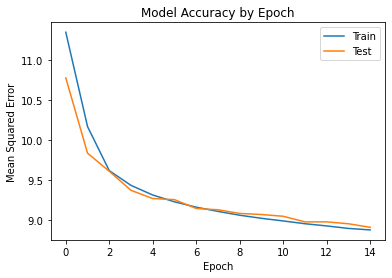

In [47]:
import matplotlib.pyplot as plt

#plot the training and validation loss over each epoch
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('Model Accuracy by Epoch')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend({'Train', 'Test'})

plt.savefig('model_acc.png', dpi=300)